In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from utils.basic_utils import *
from utils.pricing import *
from utils.imports import *
from utils.structured import *

pd.options.display.float_format = '{:,.2f}'.format

Loading utils/config.json


In [2]:
# imports
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.validation import column_or_1d
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
bench = '^GSPC'
sec_windows, stds = [5, 20, 60], 1
pred_fwd_windows = [60]
inv = incl_px = incl_name = False
y_col = 'fwdReturn'

In [4]:
%%time
# use the latest saved data for profile and quote info
dates = read_dates('quote')
tgt_date = [dates[-1]] # last date saved in S3

quotes = load_csvs('quote_consol', dates[-1:])
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

Loading file quote/csv/2019-03-13
Loading file summary-categories/assetProfile
CPU times: user 170 ms, sys: 37.8 ms, total: 208 ms
Wall time: 2.82 s


In [398]:
# utility functions
numeric_cols = lambda df: list(df.columns[df.dtypes.apply(is_numeric_dtype).values])
col_mapper = lambda pre, fields, period: {x:'_'.join([pre,x,period]) for x in fields} 
filter_cols = lambda columns, c: [x for x in columns if c in x]
day_delta = lambda df, d: df - df.shift(d)

def get_daily_ts(key, ds_dict, lookback=5):
    path = ds_dict[key]['path']
    index_col = ds_dict[key]['index']
    features = ds_dict[key]['features']
    dates = read_dates(path, '.csv')
    df = load_csvs(path, dates[-lookback:])
    df.loc[:, index_col] = pd.to_datetime(df[index_col], unit='s')
    return df.set_index(index_col, drop=True)[features]

def df_wide_transform(df, context):
    ds_dict, key = context['ds_dict'], context['key']
    periods = context['periods']
    pre = context['pre']
    
    # applies only to numeric fields
    fields = df.columns[df.dtypes.apply(is_numeric_dtype).values]
    super_list = []
    for p in periods:
        filered_df = df[df.period == p][fields]
        filered_df = filered_df.rename(columns=col_mapper(pre, fields, p))
        super_list.append(filered_df)
    return pd.concat(super_list, axis=1, sort=True).dropna(axis=1)

# pre-processing functions
def preproc_perc_price(df, context):
    ds_dict, key = context['ds_dict'], context['key']
    perc_price_cols = ds_dict[key]['perc_price']
    hist_price_df = context['hist_price']
    df.loc[:, perc_price_cols] = df[perc_price_cols] / hist_price_df.values
    return df

def preproc_divide(df, context):
    ds_dict, key = context['ds_dict'], context['key']
    divide_tuple = ds_dict[key]['divide']
    print(divide_tuple[1], divide_tuple[0])
    df.loc[:, divide_tuple[1]] =  df[divide_tuple[1]].div(df[divide_tuple[0]], axis=0)
    df.drop(columns=divide_tuple[0], inplace=True)
    return df

def preproc_scale(df, context):
    ds_dict, key = context['ds_dict'], context['key']
    scale_cols = ds_dict[key]['scale']
    # for growth we substract from prior date
    df.loc[:, scale_cols] /= df[scale_cols].max()
    return df

def preproc_eps_estimates(df, context):
    fields = df.columns[df.dtypes.apply(is_numeric_dtype).values]
    growth_cols = filter_cols(fields, 'growth')
    other_cols = excl(fields, growth_cols)
    # for growth we substract from prior date
    df.loc[:, growth_cols] = day_delta(df[growth_cols], 1)
    # shows when there are jumps on low, avg, and high estimates
    df.loc[:, other_cols] = df[other_cols].pct_change()
    return df

def preproc_day_delta(df, context): 
    fields = df.columns[df.dtypes.apply(is_numeric_dtype).values]
    return day_delta(df[fields], 1)

def preproc_eps_trend(df, context):
    super_list = []
    periods = context['periods']
    fields = df.columns[df.dtypes.apply(is_numeric_dtype).values]
    growth_cols = filter_cols(fields, 'growth')
    # for growth we substract from prior date
    df.loc[:, growth_cols] = day_delta(df[growth_cols], 1)
    for p in periods: 
        cols = filter_cols(fields, p)
        slope_cols = list(filter(lambda x, y='growth': y not in x, cols))
        print(cols, slope_cols)
        # divide current, -7, -30, and -60 days by -90 days ago for trend
        # then substract from prior day, for signal changes
        df.loc[:, slope_cols] = day_delta(df[slope_cols].div(df[slope_cols[-1]], axis=0), 1)
    return df

In [403]:
# feature mapping for different datasets
ds_dict = {
    'day_quote': {
        'path': 'quote/csv/',
        'index': 'storeDate',
        'features': [
            'regularMarketChangePercent',
            'averageDailyVolume10Day', 'averageDailyVolume3Month', 'regularMarketVolume', 
            'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent',
            'fiftyTwoWeekHighChangePercent', 'fiftyTwoWeekLowChangePercent', 
            'forwardPE', 'trailingPE', 'priceToBook', 'marketCap', 'trailingAnnualDividendYield', 
            'financialCurrency', 'symbol', ],
        'scale': ['marketCap', ],
        'divide': ('regularMarketVolume', ['averageDailyVolume10Day', 'averageDailyVolume3Month'])},
    'key_statistics': {
        'path': 'summary-categories/defaultKeyStatistics/',
        'index': 'storeDate',
        'features': [
            '52WeekChange', 'beta', 'earningsQuarterlyGrowth', 
            'enterpriseToEbitda', 'enterpriseToRevenue', 'enterpriseValue', 'forwardPE', 
            'netIncomeToCommon', 'pegRatio', 'priceToBook', 'profitMargins', 
            'shortPercentOfFloat', 'shortRatio', 'heldPercentInsiders', 
            'heldPercentInstitutions', 'symbol', ],
        'scale': ['enterpriseValue', 'netIncomeToCommon', ]},
    'eps_estimates': {
        'path': 'summary-categories/earningsEstimate/',
        'index': 'storeDate',
        'features': [
            'period', 'growth', 'avg', 'low', 'high', 'symbol', ]},
    'eps_revisions': {
        'path': 'summary-categories/epsRevisions/',
        'index': 'storeDate',
        'features': [
            'period', 'growth', 
            'upLast7days', 'upLast30days', 'downLast30days', 
            'symbol', ]},
    'eps_trend': {
        'path': 'summary-categories/epsTrend/',
        'index': 'storeDate',
        'features': [
            'period', 'growth', 
            'current', '7daysAgo', '30daysAgo', '60daysAgo', '90daysAgo', 
            'symbol', ]},
    'financial_data': {
        'path': 'summary-categories/financialData/',
        'index': 'storeDate',
        'features': [
            'currentRatio', 'debtToEquity', 'earningsGrowth', 'ebitda', 
            'ebitdaMargins', 'financialCurrency', 'freeCashflow', 'grossMargins', 
            'grossProfits', 'operatingCashflow', 'operatingMargins', 'profitMargins', 
            'quickRatio', 'recommendationKey', 'recommendationMean', 
            'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 
            'targetHighPrice', 'targetLowPrice', 'targetMeanPrice', 
            'targetMedianPrice', 'totalCash', 'totalDebt', 'totalRevenue', 
            'symbol', ],
        'scale': [
            'freeCashflow', 'operatingCashflow', 'ebitda', 
            'totalCash', 'totalDebt', 'totalRevenue', 'grossProfits', ],
        'perc_price': [
            'targetLowPrice', 'targetMeanPrice', 
            'targetMedianPrice', 'targetHighPrice', ]},
    'index_trend': {
        'path': 'summary-categories/indexTrend/',
        'index': 'storeDate',
        'features': [
            '0q', '+1q', '0y', '+1y', '+5y', '-5y', 
            'peRatio', 'pegRatio', 'symbol', ]},
    'net_purchase': {
        'path': 'summary-categories/netSharePurchaseActivity/',
        'index': 'storeDate',
        'features': [
            'netPercentInsiderShares', 'buyPercentInsiderShares', 'sellPercentInsiderShares', 
            'symbol', ]},    
    'recomm_trend': {
        'path': 'summary-categories/recommendationTrend/',
        'index': 'storeDate',
        'features': [
            'period', 
            'strongBuy', 'buy', 'hold', 'sell', 'strongSell', 
            'symbol', ]},
}



In [198]:
%%time
symbols_list = config['companies']
# px_close = get_mults_pricing(symbols_list)
# save down to drive if refresh pricing
# os.makedirs('tmp', exist_ok=True)
# px_close.to_parquet('tmp/mult-co-px-ds')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [199]:
px_close = pd.read_parquet('tmp/mult-co-px-ds')
px_close.index = px_close.index.date

### Feature construction

In [404]:
ticker = ['AAPL']
key = 'day_quote'
pre = key.split('_')[0] # append preffix
periods = ['+1q', '+1y',] # forward looking periods only

In [405]:
%%time
# retrieves dataset for historical dates
daily_df = get_daily_ts(key, ds_dict, 10)
# Make index a flat date, easier to index
daily_df.index = daily_df.index.date

Loading file quote/csv/2019-02-26
Loading file quote/csv/2019-03-04
Loading file quote/csv/2019-03-05
Loading file quote/csv/2019-03-06
Loading file quote/csv/2019-03-07
Loading file quote/csv/2019-03-08
Loading file quote/csv/2019-03-11
Loading file quote/csv/2019-03-12
Loading file quote/csv/2019-03-13
Loading file quote/csv/2019-03-14
CPU times: user 612 ms, sys: 134 ms, total: 746 ms
Wall time: 6.8 s


In [406]:
sel_co = False
if sel_co:
    active_df = daily_df[daily_df.symbol.isin(ticker)].copy()
else: 
    active_df = daily_df[daily_df.symbol.isin(symbols_list)].copy()
active_df.describe(include='all').T.sort_values(by='mean')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
regularMarketChangePercent,"12,265.00",NaN,NaN,NaN,-0.40,5.07,-100.00,-0.94,-0.11,0.63,21.91
fiftyTwoWeekHighChangePercent,"12,265.00",NaN,NaN,NaN,-0.18,0.15,-1.00,-0.27,-0.15,-0.06,0.00
fiftyDayAverageChangePercent,"12,265.00",NaN,NaN,NaN,0.01,0.10,-1.00,-0.01,0.02,0.05,1.35
twoHundredDayAverageChangePercent,"12,265.00",NaN,NaN,NaN,0.02,0.14,-1.00,-0.04,0.02,0.08,1.33
trailingAnnualDividendYield,"8,886.00",NaN,NaN,NaN,0.03,0.03,0.00,0.01,0.02,0.03,0.37
fiftyTwoWeekLowChangePercent,"12,265.00",NaN,NaN,NaN,0.33,0.39,-1.00,0.18,0.27,0.38,8.49
priceToBook,"12,265.00",NaN,NaN,NaN,2.59,61.14,"-1,940.09",1.51,2.66,5.18,724.99
forwardPE,"11,986.00",NaN,NaN,NaN,21.08,94.78,"-3,850.50",10.79,15.56,22.44,"3,114.00"
trailingPE,"10,819.00",NaN,NaN,NaN,75.41,"1,471.59",0.00,13.36,20.80,33.24,"52,350.00"
regularMarketVolume,"12,265.00",NaN,NaN,NaN,"2,589,622.15","6,631,794.36",0.00,"397,399.00","934,974.00","2,276,950.00","189,550,652.00"


In [407]:
# active_df.plot()
active_df.tail().T

,2019-03-14,2019-03-14,2019-03-14,2019-03-14,2019-03-14
regularMarketChangePercent,1.54,-0.08,-0.88,-0.75,-0.55
averageDailyVolume10Day,"2,396,675.00","2,086,987.00","5,495,087.00","2,737,862.00","1,425,987.00"
averageDailyVolume3Month,"1,970,688.00","2,672,133.00","3,378,700.00","2,529,250.00","1,306,578.00"
regularMarketVolume,"1,409,333.00","2,141,550.00","3,988,799.00","1,734,592.00","1,010,257.00"
fiftyDayAverageChangePercent,0.11,-0.01,0.01,0.06,0.06
twoHundredDayAverageChangePercent,0.29,0.02,0.11,0.07,0.11
fiftyTwoWeekHighChangePercent,-0.01,-0.17,-0.16,-0.02,-0.38
fiftyTwoWeekLowChangePercent,0.87,0.29,0.32,0.25,0.51
forwardPE,125.70,10.20,19.92,24.79,-53.41
trailingPE,NaN,12.03,21.34,32.83,NaN


In [408]:
pre_proc_pipeline = {
    'day_quote': [preproc_divide, preproc_scale],
    'key_statistics': [preproc_scale],
    'eps_estimates': [df_wide_transform, preproc_eps_estimates],
    'eps_revisions': [df_wide_transform, preproc_day_delta],
    'eps_trend': [df_wide_transform, preproc_eps_trend],
    'financial_data': [preproc_scale_financials, preproc_perc_price],
}

context = {
    'ds_dict': ds_dict,
    'key': key,
    'pre': pre,
    'periods': periods,
    'hist_price': px_close.loc[wide_df.index, ticker]
}

processed_df = active_df.copy()
if key in pre_proc_pipeline:
    for fn in pre_proc_pipeline[key]: 
        processed_df = fn(processed_df, context)
processed_df.replace([np.inf, -np.inf], np.nan, inplace=True)

processed_df.describe(include='all').T

['averageDailyVolume10Day', 'averageDailyVolume3Month'] regularMarketVolume


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
regularMarketChangePercent,"12,265.00",NaN,NaN,NaN,-0.40,5.07,-100.00,-0.94,-0.11,0.63,21.91
averageDailyVolume10Day,"12,259.00",NaN,NaN,NaN,1.32,0.53,0.00,0.97,1.24,1.56,7.46
averageDailyVolume3Month,"12,259.00",NaN,NaN,NaN,1.49,0.76,0.04,1.07,1.39,1.77,17.02
fiftyDayAverageChangePercent,"12,265.00",NaN,NaN,NaN,0.01,0.10,-1.00,-0.01,0.02,0.05,1.35
twoHundredDayAverageChangePercent,"12,265.00",NaN,NaN,NaN,0.02,0.14,-1.00,-0.04,0.02,0.08,1.33
fiftyTwoWeekHighChangePercent,"12,265.00",NaN,NaN,NaN,-0.18,0.15,-1.00,-0.27,-0.15,-0.06,0.00
fiftyTwoWeekLowChangePercent,"12,265.00",NaN,NaN,NaN,0.33,0.39,-1.00,0.18,0.27,0.38,8.49
forwardPE,"11,986.00",NaN,NaN,NaN,21.08,94.78,"-3,850.50",10.79,15.56,22.44,"3,114.00"
trailingPE,"10,819.00",NaN,NaN,NaN,75.41,"1,471.59",0.00,13.36,20.80,33.24,"52,350.00"
priceToBook,"12,265.00",NaN,NaN,NaN,2.59,61.14,"-1,940.09",1.51,2.66,5.18,724.99


In [438]:
processed_df[(np.abs(processed_df[numeric_cols(processed_df)]) > 50).any(1)].describe().T

,count,mean,std,min,25%,50%,75%,max
regularMarketChangePercent,"2,008.00",-1.48,11.87,-100.00,-0.90,-0.02,0.76,19.78
averageDailyVolume10Day,"2,008.00",1.34,0.56,0.00,0.98,1.27,1.63,5.02
averageDailyVolume3Month,"2,008.00",1.48,0.78,0.07,1.02,1.38,1.80,16.13
fiftyDayAverageChangePercent,"2,008.00",0.02,0.14,-1.00,0.00,0.03,0.07,0.36
twoHundredDayAverageChangePercent,"2,008.00",0.06,0.18,-1.00,-0.00,0.07,0.14,0.54
fiftyTwoWeekHighChangePercent,"2,008.00",-0.15,0.16,-1.00,-0.20,-0.10,-0.04,0.00
fiftyTwoWeekLowChangePercent,"2,008.00",0.51,0.69,-1.00,0.25,0.39,0.61,8.49
forwardPE,"1,998.00",49.29,229.12,"-3,850.50",19.26,32.14,55.30,"3,114.00"
trailingPE,"1,635.00",383.17,"3,771.61",0.00,51.79,64.35,99.00,"52,350.00"
priceToBook,"2,008.00",-1.95,150.57,"-1,940.09",2.08,5.23,12.47,724.99


In [343]:
processed_df.tail().T

,2019-03-07,2019-03-08,2019-03-11,2019-03-12,2019-03-13
eps_growth_+1q,0.00,0.00,0.00,0.00,0.00
eps_upLast7days_+1q,0.00,-1.00,0.00,0.00,0.00
eps_upLast30days_+1q,0.00,0.00,0.00,0.00,0.00
eps_downLast30days_+1q,0.00,0.00,0.00,1.00,0.00
eps_growth_+1y,0.00,0.00,0.00,0.00,0.00
eps_upLast7days_+1y,0.00,0.00,0.00,0.00,0.00
eps_upLast30days_+1y,0.00,0.00,0.00,0.00,0.00
eps_downLast30days_+1y,0.00,0.00,0.00,0.00,0.00


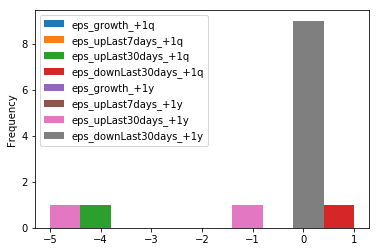

In [342]:
processed_df.plot.hist()

### Get universe dataset

In [345]:
ticker = ['AAPL']
key = 'day_quote'
pre = key.split('_')[0] # append preffix
periods = ['+1q', '+1y',] # forward looking periods only

In [347]:
%%time
# retrieves dataset for historical dates
daily_df = get_daily_ts(key, ds_dict, 10)
# Make index a flat date, easier to index
daily_df.index = daily_df.index.date

Loading file quote/csv/2019-02-26
Loading file quote/csv/2019-03-04
Loading file quote/csv/2019-03-05
Loading file quote/csv/2019-03-06
Loading file quote/csv/2019-03-07
Loading file quote/csv/2019-03-08
Loading file quote/csv/2019-03-11
Loading file quote/csv/2019-03-12
Loading file quote/csv/2019-03-13
Loading file quote/csv/2019-03-14
CPU times: user 637 ms, sys: 127 ms, total: 763 ms
Wall time: 6.62 s


In [348]:
# pre-processing pipeline
pre_proc_pipeline = {
    'key_statistics': [preproc_scale_financials],
    'eps_estimates': [df_wide_transform, preproc_eps_estimates],
    'eps_revisions': [df_wide_transform, preproc_day_delta],
    'eps_trend': [df_wide_transform, preproc_eps_trend],
    'financial_data': [preproc_scale_financials, preproc_perc_price],
}

In [ ]:

context = {
    'ds_dict': ds_dict,
    'key': key,
    'pre': pre,
    'periods': periods,
    'hist_price': px_close.loc[wide_df.index, ticker]
}

processed_df = active_df.copy()
if key in pre_proc_pipeline:
    for fn in pre_proc_pipeline[key]: 
        processed_df = fn(processed_df, context)
    
processed_df

### Get universe pricing

In [30]:
# use the latest saved data for profile and quote info
dates = read_dates('quote')
tgt_date = [dates[-1]] # last date saved in S3

quotes = load_csvs('quote_consol', tgt_date)
quotes.set_index('symbol', drop=False, inplace=True)
profile = load_csvs('summary_detail', ['assetProfile'])
profile.set_index('symbol', drop=False, inplace=True)

Loading file quote/csv/2019-03-12
Loading file summary-categories/assetProfile


In [31]:
profile.drop(profile[profile.symbol.isin(excl_list)].index, inplace=True)

all_equities = quotes[quotes.quoteType == 'EQUITY'].symbol.unique()
print('Delta quote: ', set(symbols_list) - set(all_equities))
# reduced subset, if any
sub_equities = set(px_close.columns.tolist()).intersection(all_equities)
print('Delta reduced set: ', set(symbols_list) - set(sub_equities))

eqty_symbols = profile[profile.symbol.isin(sub_equities)].symbol.unique().tolist()
delta_symb = set(symbols_list) - set(eqty_symbols)
print('Delta profile: ', len(delta_symb), delta_symb)

Delta quote:  {'FBR', 'SCG', 'SHPG', 'PD'}
Delta reduced set:  {'FBR', 'SCG', 'SHPG', 'PD'}
Delta profile:  23 {'ESL', 'SHPG', 'AMED', 'JBT', 'ODFL', 'IBKR', '9984.T', 'REGN', 'CBOE', 'SCG', 'ROP', 'BSTI', 'VVC', 'ABMD', 'PD', 'FBR', 'LRCX', 'DRE', 'KORS', 'DNB', 'WSM', 'TAP', 'NFX'}


In [32]:
# Create a frame of market, sector and industry index (once)
# for relative performance calculations
sel_profiles = profile[profile.symbol.isin(all_equities)]
sel_profiles.groupby(['sector', 'industry'])[['industry']].count()
sectors = sel_profiles.sector.unique()
industries = sel_profiles.industry.unique()

f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}'

'Sectors: 11, Industries: 136'

In [33]:
%%time
indices_df = pd.concat([
    eq_wgt_indices(profile, px_close, 'sector', sectors, subset=eqty_symbols),
    eq_wgt_indices(profile, px_close, 'industry', industries, subset=eqty_symbols),
    to_index_form(get_symbol_pricing(bench)['close'], bench)
], axis=1)

CPU times: user 11 s, sys: 1.7 s, total: 12.7 s
Wall time: 3.71 s


### Dataset creation

In [570]:
%%time
# Take a while ~40min to run on 1200 companies

super_list = []
for ticker in tqdm(eqty_symbols[:200]):
    
    df = get_symbol_pricing(ticker)
    ft_df = px_mom_feats(
        df, ticker, stds, inv, incl_px, 
        sec_windows, incl_name)
    
    ft_df[y_col] = px_fwd_rets(
        df.close, ticker, pred_fwd_windows).mean(axis=1)
    
    co = px_mom_co_feats(
        df, indices_df, 
        [bench] + list(profile.loc[ticker, ['sector', 'industry']]))

    ft_df.loc[:, 'country'] = profile.loc[ticker,:].country
    ft_df.loc[:, 'currency'] = quotes.loc[ticker,:].currency
    
    ft_df = pd.concat([ft_df, co], axis=1)
    super_list.append(ft_df)

df_large = pd.concat(super_list, axis=0)

100%|██████████| 200/200 [01:08<00:00,  3.04it/s]
CPU times: user 33.6 s, sys: 1.03 s, total: 34.7 s
Wall time: 1min 9s


In [539]:
os.makedirs('tmp', exist_ok=True)
df_large.to_parquet('tmp/company-px_mom-large')

### Old pre-processing

In [35]:
cuts = { '1d': [-1, -0.1, -.02, .02, .1, 1.] }
cut_range = cuts['1d']
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

df_large = pd.read_parquet('tmp/company-px_mom-large')
print(df_large.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 781600 entries, 2004-03-08 00:00:00-05:00 to 2019-03-11 00:00:00-04:00
Columns: 29 entries, PctChg1Stds to industry
dtypes: float64(24), object(5)
memory usage: 178.9+ MB
None


In [36]:
# Trims dataset in case it's too large for experimentation
# Reduce dataset for experimentation
# Note that experiment dataset is not stratified
exp_perc = 99e-2
_, df_raw = train_test_split(df_large, test_size=exp_perc, shuffle=True, )

df_raw.dropna(subset=[y_col],  inplace=True)
df_raw[y_col] = discret_rets(df_raw[y_col], cut_range, fwd_ret_labels)

# df_raw.loc[:, y_col] = df_raw[y_col].astype(str)

y_col_dist = sample_wgts(df_raw[y_col], fwd_ret_labels)
(y_col_dist[fwd_ret_labels]).round(3)

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


bear      0.17
short     0.18
neutral   0.13
long      0.24
bull      0.28
Name: fwdReturn, dtype: float64

In [37]:
# keep_col = ['Pct52WkL', 'RollVol20', 'PctMA200', 'rsBench120', 
#             'rsSect120', 'Pct52WkH', 'PctChg60', 'rsSect60', 
#             'PctMA50', 'rsInd60', 'rsInd120', 'rsBench60', 'rsInd20', 
#             'PctChg20', 'PctChg5', 'rsSect20', 'rsBench20', 'volPctMa10', 
#             'volPctMa60',  y_col]
# df_raw = df_raw[keep_col]

# df_raw = df_raw[df_raw.sector.isin(['Healthcare'])][keep_col]
# df_raw = df_raw[df_raw.symbol.isin(['AAPL'])]

In [38]:
%%time
# turn sectors into dummies
def dummy_col(df, col):
    df.loc[:, col] = df[col].apply(shorten_name)
    df = pd.concat([df, pd.get_dummies(df[col])], axis=1)
    return df
    
df_raw = dummy_col(df_raw, 'sector')
df_raw = dummy_col(df_raw, 'industry')
df_raw = dummy_col(df_raw, 'country')
df_raw = dummy_col(df_raw, 'currency')

/Users/vveiga/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


CPU times: user 9.64 s, sys: 1.2 s, total: 10.8 s
Wall time: 4.27 s


In [39]:
%%time
excl_list = ['symbol', 'country', 'currency', 'industry', 'sector'] # drop unneeded columns
df_raw.drop(columns=excl_list, inplace=True, errors='ignore')

# train_cats(df_raw) # train categories excluding Y variable
# categ_cols = excl(df_raw.dtypes[df_raw.dtypes == 'category'].index, [y_col])
# df_raw.loc[:, categ_cols] = df_raw[categ_cols].apply(lambda x: x.cat.codes)

# lots of calculations so replace infinity with nan
df_raw.replace([np.inf, -np.inf], np.nan, inplace=True)
df_raw.shape

CPU times: user 13.4 s, sys: 2.33 s, total: 15.7 s
Wall time: 11.6 s


In [40]:
df_raw.columns

Index(['PctChg1Stds', 'PctMA50', 'PctMA200', 'RollVol20', 'PctChg5',
       'PctChg20', 'PctChg60', 'Pct52WkH', 'Pct52WkL', 'fwdReturn',
       ...
       '^MEXI', '^PERU', '^SOUT_AFRI', '^SPAI', '^SWIT', '^TAIW', '^UNIT_KING',
       '^UNIT_STAT', '^HKD', '^USD'],
      dtype='object', length=131)

In [41]:
drop_dates = True

if drop_dates: df_raw.reset_index(drop=True, inplace=True)
else: 
    df_raw.reset_index(inplace=True)
    df_raw.rename({'index': 'obsDate'}, axis=1, inplace=True)
    add_datepart(df_raw, 'obsDate')
    
# df_raw[[x for x in df_raw.columns if 'obs' in x]]
# exp_log['drop_dates'] = drop_dates

### Train models

In [43]:
%%time
# Mean based imputer
imputer_on, scaler_on = True, False
imputer = SimpleImputer(missing_values=np.nan, strategy='mean', copy=False)
scaler = StandardScaler()

pre_ml_df = df_raw.copy()
pre_ml_df.dropna(subset=[y_col], inplace=True)
pre_ml_df.loc[:, y_col] = pre_ml_df[y_col].astype(str)
X_cols = excl(pre_ml_df.columns, [y_col])

if imputer_on: pre_ml_df.loc[:, X_cols] = imputer.fit_transform(pre_ml_df[X_cols])
else: pre_ml_df.dropna(inplace=True)
if scaler_on: pre_ml_df.loc[:, X_cols] = scaler.fit_transform(pre_ml_df[X_cols])

X, y = pre_ml_df.drop(columns=y_col), pre_ml_df[y_col]

# sample_weight = np.random.RandomState(42).rand(y.shape[0])
# X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X, y, sample_weight, test_size=.20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

CPU times: user 58.8 s, sys: 41.3 s, total: 1min 40s
Wall time: 21.6 s


In [44]:
%%time

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

# RandomForestClassifier
params = {
    'n_estimators': 100, 
    'max_features': X.shape[1] // 2, 
    'random_state': 4,
    'max_depth': None, 
    'min_samples_split': 2, 
    'n_jobs': -1}

clf = RandomForestClassifier(**params)
clf.fit(X_train, y_train)

scores = clf.score(X_train, y_train), clf.score(X_test, y_test)
print(scores)

(0.9996839596941971, 0.7672793547386382)
CPU times: user 51min, sys: 13.6 s, total: 51min 14s
Wall time: 4min 40s


In [455]:
%%time
# ExtraTreesClassifier
clf = ExtraTreesClassifier(
    n_estimators=100, max_depth=None, 
    min_samples_split=2, random_state=0, n_jobs=-1)

clf.fit(X_train, y_train)
scores = clf.score(X_train, y_train), clf.score(X_test, y_test)
print(scores)

(1.0, 0.6980117261318302)
CPU times: user 5min 38s, sys: 9.13 s, total: 5min 48s
Wall time: 32.6 s


In [546]:
%%time
# MLPClassifier
params = {
    'activation': 'relu', 
    'alpha': 0.01, 
    'hidden_layer_sizes': (15,), 
    'learning_rate': 'adaptive', 
    'max_iter': 200, 
    'random_state': 3, 
    'solver': 'lbfgs'}

clf = MLPClassifier(**params)

clf.fit(X_train, y_train)
scores = clf.score(X_train, y_train), clf.score(X_test, y_test)
print(scores)

(0.3481954484812758, 0.347108784176847)
CPU times: user 4min 48s, sys: 29.6 s, total: 5min 17s
Wall time: 57.1 s


#### Metrics

Loading file quote/csv/2019-03-11
Loading file summary-categories/assetProfile
Loading file quote/csv/2019-03-11
Loading file summary-categories/assetProfile
Feature ranking:
3 feature RollVol20 (0.055379084768897746)
8 feature Pct52WkL (0.05079081328218158)
2 feature PctMA200 (0.04847372429599919)
7 feature Pct52WkH (0.0480753794115999)
15 feature rsBench120 (0.04614337927974544)
16 feature rsSect120 (0.04597819379961842)
17 feature rsInd120 (0.04590586834716318)
6 feature PctChg60 (0.04510817351310645)
1 feature PctMA50 (0.044538316880500986)
14 feature rsInd60 (0.044258431832974336)
12 feature rsBench60 (0.044035389786850926)
13 feature rsSect60 (0.043856256652849784)
11 feature rsInd20 (0.041575652631080616)
5 feature PctChg20 (0.04136692973989873)
9 feature rsBench20 (0.04108225365353204)
10 feature rsSect20 (0.04096942397498883)
4 feature PctChg5 (0.03933564999679525)
19 feature volPctMa60 (0.0353012262234468)
18 feature volPctMa10 (0.03519117915811156)
0 feature PctChg1Stds (0.0

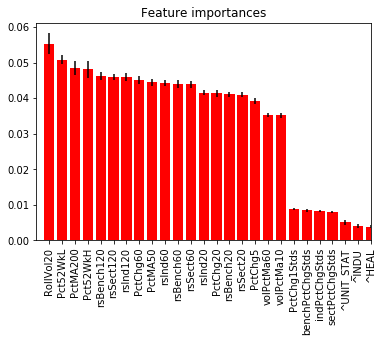

In [533]:
show_fi(clf, X, 25)

In [534]:
print('Confussion Matrix\n', confusion_matrix(clf.predict(X_test), y_test, labels=fwd_ret_labels))

Confussion Matrix
 [[17098  2047   363   352   218]
 [ 1755 15847  2658   558   180]
 [   51  1595  6412  1339    57]
 [  781  1857  5004 23398  3253]
 [ 1638  2128  1755  5593 32988]]


In [535]:
print('Classificaton report\n', classification_report(clf.predict(X_test), y_test, target_names=fwd_ret_labels))

Classificaton report
               precision    recall  f1-score   support

        bear       0.80      0.85      0.83     20078
       short       0.90      0.75      0.82     44102
     neutral       0.75      0.68      0.71     34293
        long       0.40      0.68      0.50      9454
        bull       0.68      0.75      0.71     20998

   micro avg       0.74      0.74      0.74    128925
   macro avg       0.70      0.74      0.71    128925
weighted avg       0.77      0.74      0.75    128925



In [536]:
log_loss(y_test, clf.predict_proba(X_test))

0.945469193272936

#### Gridsearches

In [342]:
np.arange(10, X.shape[1], int(X.shape[1]*.25))

array([10, 36, 62, 88])

In [ ]:
%%time
# GridSearchCV for RandomForestClassifier
parameters = {
    'n_estimators': [10, 20, 40], 
    'max_features': np.arange(10, X.shape[1], int(X.shape[1]*.25)), 
    'random_state': np.arange(1, 10, 3)}

# parameters = {
#     'n_estimators': [80], 
#     'max_features': [16], 
#     'random_state': [4]}

clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1, cv=5)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train), clf.score(X_test, y_test))
print(clf.best_params_)

### Date and minute based time analysis

In [1007]:
freq = '1d'

In [1008]:
# s1, s2 = '1810.HK', 'AAPL'
group_pricing = pd.DataFrame()
df1 = get_symbol_pricing(s1, freq, ['close'])
df2 = get_symbol_pricing(s2, freq, ['close'])
group_pricing = pd.DataFrame(df1)
# group_pricing.loc[:, s2] = df2
group_pricing = pd.concat([group_pricing, df2], axis=1)
group_pricing.describe()
# group_pricing

,close,close
count,164.00,"3,775.00"
mean,14.24,66.80
std,2.88,56.49
min,9.70,1.81
25%,12.19,16.67
50%,13.59,54.28
75%,16.51,106.82
max,21.55,232.07


In [850]:
path = config['pricing_path'].format(freq)
data_dict = json_load(path + json_ext.format(ticker))

tz = data_dict['meta']['exchangeTimezoneName']
df = build_px_struct(data_dict, freq)

adjClose = data_dict['indicators']['adjclose'][0] if 'adjclose' in  data_dict['indicators'] else 0
close = data_dict['indicators']['quote'][0]
data_dict.keys(), data_dict['indicators'].keys()

(dict_keys(['meta', 'timestamp', 'indicators']), dict_keys(['quote']))

In [916]:
df.index.date

array([datetime.date(2019, 2, 28), datetime.date(2019, 2, 28),
       datetime.date(2019, 2, 28), ..., datetime.date(2019, 3, 6),
       datetime.date(2019, 3, 6), datetime.date(2019, 3, 6)], dtype=object)

In [851]:
dates = pd.to_datetime(
        data_dict['timestamp'], 
        unit='s', infer_datetime_format=True)
# dates = dates.astype(f'datetime64[ns, {tz}]')
# dates.tz_convert('America/New_York')
# dates = dates.tz_localize('America/New_York')
dates.floor('d' if freq == '1d' else 'min')

DatetimeIndex(['2019-02-28 14:30:00', '2019-02-28 14:31:00',
               '2019-02-28 14:32:00', '2019-02-28 14:33:00',
               '2019-02-28 14:34:00', '2019-02-28 14:35:00',
               '2019-02-28 14:36:00', '2019-02-28 14:37:00',
               '2019-02-28 14:38:00', '2019-02-28 14:39:00',
               ...
               '2019-03-06 20:50:00', '2019-03-06 20:51:00',
               '2019-03-06 20:52:00', '2019-03-06 20:53:00',
               '2019-03-06 20:54:00', '2019-03-06 20:55:00',
               '2019-03-06 20:56:00', '2019-03-06 20:57:00',
               '2019-03-06 20:58:00', '2019-03-06 20:59:00'],
              dtype='datetime64[ns]', length=1950, freq=None)

In [829]:
df.tail(5)

,high,low,open,close,adjclose,volume
2019-03-06 20:55:00,174.72,174.60,174.66,174.71,0,"148,802.00"
2019-03-06 20:56:00,174.73,174.67,174.67,174.71,0,"37,980.00"
2019-03-06 20:57:00,174.72,174.65,174.71,174.65,0,"70,312.00"
2019-03-06 20:58:00,174.80,174.64,174.65,174.76,0,"105,856.00"
2019-03-06 20:59:00,174.82,174.46,174.74,174.51,0,"385,081.00"


In [1018]:
freq = '1d'

In [1019]:
%time px_close = get_mults_pricing(symbols_list[:10], freq);

Retrieved pricing for 0700.HK
Retrieved pricing for 1810.HK
Retrieved pricing for 3690.HK
Retrieved pricing for 9984.T
Retrieved pricing for A
Retrieved pricing for AAL
Retrieved pricing for AAN
Retrieved pricing for AAON
Retrieved pricing for AAP
Retrieved pricing for AAPL
CPU times: user 1.05 s, sys: 45.5 ms, total: 1.1 s
Wall time: 3.91 s


In [1022]:
# [px_close[x].dropna().tail() for x in px_close.columns]
px_close.describe()
# px_close.tail()

,0700.HK,0700.HK,1810.HK,3690.HK,9984.T,A,AAL,AAN,AAON,AAP,AAPL
count,"3,634.00","3,634.00",164.00,111.00,"3,743.00","3,775.00","3,382.00","3,775.00","1,258.00","3,775.00","3,775.00"
mean,94.03,94.03,14.24,54.89,"4,406.54",33.28,26.97,23.86,28.76,81.72,66.80
std,115.76,115.76,2.88,7.61,"2,785.93",15.49,17.32,10.35,6.93,49.29,56.49
min,0.68,0.68,9.70,41.20,650.00,8.90,1.76,9.33,16.97,22.10,1.81
25%,9.51,9.51,12.19,48.45,"2,148.00",22.63,9.12,14.67,22.29,39.16,16.67
50%,40.18,40.18,13.59,55.00,"2,960.00",27.83,30.26,23.71,28.15,66.07,54.28
75%,142.08,142.08,16.51,59.82,"7,127.50",40.84,42.34,29.12,35.06,126.80,106.82
max,474.60,474.60,21.55,72.65,"11,470.00",81.24,62.95,55.45,43.83,200.38,232.07


In [1023]:
f'Ticker: {ticker}'

'Ticker: AAPL'

In [1024]:
px = get_symbol_pricing(ticker, freq)
px.close.tail()

2019-02-28 00:00:00-05:00   173.15
2019-03-01 00:00:00-05:00   174.97
2019-03-04 00:00:00-05:00   175.85
2019-03-05 00:00:00-05:00   175.53
2019-03-06 00:00:00-05:00   174.52
Name: close, dtype: float64

### Other

In [320]:
# does the DS need to be transform from long to wide?
# made this function part of the pre_processing pipeline
if 'period' in active_df.columns:
    active_df.groupby(by='period').count()
    active_df = df_wide_transform(active_df, periods, pre)
active_df.describe().T

In [ ]:
# divide target Low, Mean, Median, and High by closing price
ds_dict, key = context['ds_dict'], context['key']
perc_price_cols = ds_dict[key]['perc_price']
hist_price_df = px_close.loc[wide_df.index, ticker]
(wide_df[perc_price_cols] / hist_price_df.values).plot()

In [ ]:
# eps_revisions pivot transformations
def pivot_frame(df, inds, cols, vals):
    pvt_df = df.pivot_table(index=inds, columns=cols, values=vals)
    return pvt_df

pvt_df = pivot_frame(one_co, ['storeDate', 'symbol'], ['period'], ['avg'])
# drop index after numerial operations
delta = (pvt_df - pvt_df.shift(1)).dropna()
delta.reset_index(level=1, inplace=True)
delta.tail(20)

In [490]:
# applies only to numeric fields
fields = one_co.columns[one_co.dtypes.apply(is_numeric_dtype).values]
super_list = []
for p in periods:
    p_filter = one_co[one_co.period == p].sort_index()[fields]
    df = p_filter.rename(columns=col_mapper(pre, fields, p))
    super_list.append(df)
wide_df = pd.concat(super_list, axis=1, sort=True)

In [151]:
dates = ['quote/', 'quote/2018-09-07.json', 'quote/2018-09-10.json', 'quote/2018-09-11.json', 'quote/2018-09-12.json',]
# s = 'quote/2018-09-07.json'
[s[::-1].split('/')[0][::-1].split(ext)[0] for s in dates if ext in s]

['2018-09-07', '2018-09-10', '2018-09-11', '2018-09-12']

In [ ]:
s3client = boto3.client('s3', 'us-west-2')
ext = '.csv'
dataset = 'summary-categories/defaultKeyStatistics/'
ds_list = [x['Key'] for x in s3client.list_objects(Bucket=BUCKET_NAME, Prefix=dataset)['Contents']]
ds_list = [s[::-1].split('/')[0][::-1].split(ext)[0] for s in ds_list if ext in s]
sorted(ds_list)

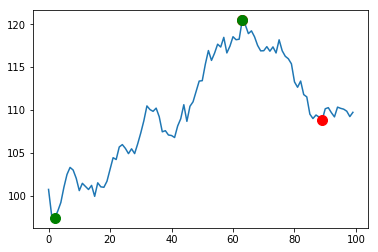

In [8]:
# Test cumulative drawdowns and pulls
n = 100
r_w = np.random.randn(n).cumsum() + 100
l_dd, h_dd, l_p, h_p = max_draw_pull(r_w)

plt.plot(r_w)
plt.plot(
    [l_dd, h_dd], 
    [r_w[l_dd], r_w[h_dd],], 
    'o', color='Red', markersize=10)
plt.plot(
    [l_p, h_p], 
    [r_w[l_p], r_w[h_p]], 
    'o', color='Green', markersize=10)

In [1103]:
# Retrieves historical pricing
secpx = get_symbol_pricing(symbol, freq)
secpx.set_index(secpx.index.astype(np.datetime64), inplace=True)

In [1110]:
fwd_ss_ret = lambda x, df, arr: df.loc[[y for y in arr[x-1] if y in df.index.tolist()]].mean()

In [1111]:
# seasonality analysis
ss_df = closepx.pct_change().resample('M').sum().to_frame()
ss_df['year'], ss_df['month'] = ss_df.index.year, ss_df.index.month
ss_df = ss_df.pivot_table(index='year', columns='month').mean()
ss_pos = [(x, (x+1) if not (x+1) // 12 else 0, 
     x+2 if not (x+2) // 12 else x - 10) for x in range(12)]

# [fwd_ss_ret(x+1, ss_df['close'], ss_pos) for x in range(12)] # test

In [1112]:
# apply seasonality, mean return of curr month plus next two
secpx['month'] = secpx.index.month
secpx['fwdSSRet'] = secpx.loc[:].month.apply(
    fwd_ss_ret, args=(ss_df['close'], ss_pos,))

In [ ]:
secpx.columns # all columns

In [ ]:
# normalized columns for ML training, still has outliers
ml_ds_cols = secpx.describe().loc['50%'][secpx.describe().loc['50%'] < 5].index.tolist()
ml_ds_cols

In [ ]:
# prepare ML dataset
ml_ds = secpx[ml_ds_cols].copy()

class_cols = ['fwdChg1w', 'fwdChg1m', 'fwdChg3m']
cut_range = [-1, -0.05, .0, .02, .09, 1.]
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]

for c in class_cols: ml_ds[c] = pd.cut(secpx[c], cut_range, labels=fwd_ret_labels)
ml_ds.info()

In [ ]:
# drop the predicting class with most nas
ml_ds.dropna(inplace=True)
ml_ds.info()

In [ ]:
ml_ds.hist(figsize=(15,15));

In [622]:
ml_ds.to_csv(csv_ext.format('co_price_mom_ds'), index=False)